In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
# !pip install sentencepiece
# !pip install torch
# !pip install transformers
# !pip install rouge_score

In [3]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import time

import pandas as pd
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, PegasusConfig
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer


In [4]:
#globals
MAX_LENGTH = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
#dataset and tokenizer building
#load our 10k data into a dataframe
limit = 10000
papers = []
for root, dirs, files in os.walk("./data/mini_10k"):
    for f in files:
        fn = root+"/"+f
        with open(fn) as jsonfile:
            d = json.load(jsonfile)
        papers.append(d)
        
        if len(papers) >= limit:
            break
    if len(papers) >= limit:
        break
df = pd.DataFrame(papers)

In [6]:
#load our rouge scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)

In [7]:
#load our pretrained model
model_name = 'google/pegasus-large'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
config = PegasusConfig.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)  
pt_model = PegasusForConditionalGeneration.from_pretrained(model_name, config=config).to(device)

In [8]:
#example batch (size 1)
#print(df)
batch = tokenizer(df.fulltext[3], truncation=True, padding='longest', return_tensors="pt").to(device)
print(batch.keys())

dict_keys(['input_ids', 'attention_mask'])


In [9]:
#example pretrained generation with keys
out = pt_model.generate(return_dict_in_generate=True, **batch)
print(out.keys())
print(len(out["encoder_hidden_states"]))

odict_keys(['sequences', 'encoder_attentions', 'encoder_hidden_states', 'decoder_attentions', 'cross_attentions', 'decoder_hidden_states'])
17


In [8]:
class AttentionAttention(nn.Module):
    def __init__(self,  
                 vocab_size=32000, 
                 input_size=1024, 
                 target_size=256):
        super(AttentionAttention, self).__init__()
        
        
        #attn head1
        self.ah1_1 = nn.Linear(input_size, target_size)
        self.ah1_2 = nn.Linear(target_size, target_size//2)
        self.ah1_3 = nn.Linear(target_size//2, target_size//4)
        
        #attn head2
        self.ah2_1 = nn.Linear(input_size, target_size)
        self.ah2_2 = nn.Linear(target_size, target_size//2)
        self.ah2_3 = nn.Linear(target_size//2, target_size//4)
        
        #attn head3
        self.ah3_1 = nn.Linear(input_size, target_size)
        self.ah3_2 = nn.Linear(target_size, target_size//2)
        self.ah3_3 = nn.Linear(target_size//2, target_size//4)
        
        #attn head4
        self.ah4_1 = nn.Linear(input_size, target_size)
        self.ah4_2 = nn.Linear(target_size, target_size//2)
        self.ah4_3 = nn.Linear(target_size//2, target_size//4)
 
        #compression layer
        self.fc_comp = nn.Linear(target_size//2, target_size//2)
        
        #output head
        self.fc_out = nn.Linear(target_size//2, vocab_size)
        
        #dropout layer
        self.do = nn.Dropout(p=0.2)
        
        #softmax layer
        self.sm = nn.Softmax(dim=1)
            
        #mapping variable
        self.node2attn = {}
        
    def forward(self, out, print_attn=False):
        
        
        assert(len(out["encoder_attentions"])==16)
        
        #initialize a random tensor as our 'shallow' attn
        shallow_attn1 = torch.rand((1024,1024), requires_grad=True).to(device)
        shallow_attn2 = torch.rand((1024,1024), requires_grad=True).to(device)
        #shallow_attn3 = torch.rand((1024,1024), requires_grad=True).to(device)
        #shallow_attn4 = torch.rand((1024,1024), requires_grad=True).to(device)
        
        #pull only from these attn layers
        self.node2attn = {
            0:shallow_attn1,
            1:shallow_attn2,
            #2:shallow_attn3,
            #4:shallow_attn4,
        }
        
        for i,attn in enumerate(out["encoder_attentions"]):
            if i not in self.node2attn:
                continue
            
            for j,block in enumerate(attn[0]):
                attn = torch.tensor(block).to(device)
                
                #get our shallow attn tensor (right now just noise)
                shallow_attn = self.node2attn[i]
                
                #experiment 0
                #add our attention to the noise
                shallow_attn = shallow_attn.add(attn)
                
                # experiment 1, ab,cd->bc
                #shallow_attn = torch.einsum("ab,cd->bc", shallow_attn, attn)
                
                #experiment 2, ab,cd->ad
                shallow_attn = torch.einsum("ab,cd->ad", shallow_attn, attn)
                
                #optional debug, print attn
                if print_attn:
                    plt.matshow(shallow_attn.cpu().detach().numpy())
                    plt.show()
                
                
                
                #just take the first shallow attn
                #break out from inner loop
                break
                    
        
        
        #values,indices = torch.sort(global_attn)
        
        
        #learn from shallow_attn1
        x1 = F.relu(self.ah1_1(shallow_attn1))
        x1 = F.relu(self.ah1_2(x1))
        x1 = F.relu(self.ah1_3(x1))
        
        #learn from shallow_attn2
        x2 = F.relu(self.ah2_1(shallow_attn2))
        x2 = F.relu(self.ah2_2(x2))
        x2 = F.relu(self.ah2_3(x2))
        
        #learn from shallow_attn3
#         x3 = F.relu(self.ah3_1(shallow_attn3))
#         x3 = F.relu(self.ah3_2(x3))
#         x3 = F.relu(self.ah3_3(x3))
        
#         #learn from shallow_attn4
#         x4 = F.relu(self.ah4_1(shallow_attn4))
#         x4 = F.relu(self.ah4_2(x4))
#         x4 = F.relu(self.ah4_3(x4))
                
        #concatenate all heads
        #print(x1.shape, x2.shape, x3.shape)
        x_concat = torch.cat((x1,x2), 1)
        
        #print(x_concat.shape)

        x = F.relu(self.fc_comp(x_concat))
        
        #add dropout
        x = self.do(x)
        
        #print(x.shape)
        
        #run through our final output layer
        x = F.relu(self.fc_out(x))
        
        #print(x.shape)

        return x

In [9]:
aa = AttentionAttention(vocab_size=tokenizer.vocab_size).to(device)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


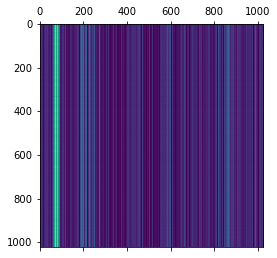

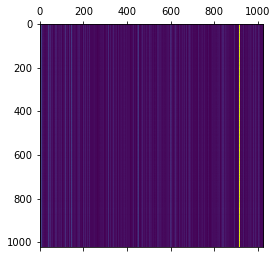

torch.Size([1024, 128])
torch.Size([1024, 96103])


torch.Size([1024, 96103])

In [20]:
o3 = aa.forward(out, print_attn=True)
o3.shape

In [10]:
def summary2tensor(summary, batch_size=1, vocab_size=32000):
    z = torch.zeros(vocab_size, dtype=torch.int64).to(device)
    for i,wid in enumerate(summary):   
        z[i] = wid
    return z


def pred2tensor(pred):
    ids = []
    for r in pred:
        idx = torch.argmax(r)
        ids.append(idx)
    return torch.tensor(ids)

In [29]:
#load the model from disk
aa = AttentionAttention(vocab_size=tokenizer.vocab_size).to(device)
aa.load_state_dict(torch.load("data/a1v2_model.state"))
aa.eval()

AttentionAttention(
  (ah1_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah1_2): Linear(in_features=256, out_features=128, bias=True)
  (ah1_3): Linear(in_features=128, out_features=64, bias=True)
  (ah2_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah2_2): Linear(in_features=256, out_features=128, bias=True)
  (ah2_3): Linear(in_features=128, out_features=64, bias=True)
  (ah3_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah3_2): Linear(in_features=256, out_features=128, bias=True)
  (ah3_3): Linear(in_features=128, out_features=64, bias=True)
  (ah4_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah4_2): Linear(in_features=256, out_features=128, bias=True)
  (ah4_3): Linear(in_features=128, out_features=64, bias=True)
  (fc_comp): Linear(in_features=128, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=96103, bias=True)
  (do): Dropout(p=0.2, inplace=False)
)

In [11]:
#run model in parallel
#aa = nn.DataParallel(aa)

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.CategoricalCrossEntropyLoss()
#loss_fn = torch.nn.MSELoss()
#torch.nn.CrossEntropyLoss

#loss_fn = nn.NLLLoss()


for param in aa.parameters():
    param.requires_grad = True

lr = 5.0 # learning rate
optimizer = torch.optim.SGD(aa.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
ntokens = tokenizer.vocab_size
ts = time.time()
for i in range(len(papers)):
    
    batch = tokenizer(df.fulltext[i], truncation=True, padding='longest', return_tensors="pt").to(device)
    
    out = pt_model.generate(return_dict_in_generate=True, **batch)
    
    try:
        y_pred = aa.forward(out)
    except Exception as e:
        print(e)
        continue
        
    y = tokenizer(df.summary[i], truncation=True, padding='longest', return_tensors="pt").to(device)
    y = y["input_ids"][0]
    
    y_true = torch.zeros(1024, dtype=torch.int64).to(device)
    for j,x in enumerate(y):
        y_true[j] = x
    
    #print(y_true)
    #print(y_pred)
    #y_true = summary2tensor(y, batch_size=1024, vocab_size=tokenizer.vocab_size)
    #print(pred.shape, y.shape)
    #print(pred)
    #loss = loss_fn(torch.log(y_pred), y_true)
    loss = loss_fn(y_pred, y_true)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0 and i > 0:
        torch.save(aa.state_dict(), "data/a1v2_model.state")
        print("Iteration {} model saved".format(i))
        print("{} {}".format(i, loss.item()))

te = time.time() 
print("Completed in {} seconds".format(int(te-ts)))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration 10 model saved
10 16.629436492919922
Iteration 20 model saved
20 nan
Iteration 30 model saved
30 nan
Iteration 40 model saved
40 nan
Iteration 50 model saved
50 nan
Iteration 60 model saved
60 nan
The size of tensor a (1024) must match the size of tensor b (948) at non-singleton dimension 1
Iteration 70 model saved
70 nan
Iteration 80 model saved
80 nan
Iteration 90 model saved
90 nan
Iteration 100 model saved
100 nan
Iteration 110 model saved
110 nan
Iteration 120 model saved
120 nan
Iteration 130 model saved
130 nan
Iteration 140 model saved
140 nan
Iteration 150 model saved
150 nan
Iteration 160 model saved
160 nan
Iteration 170 model saved
170 nan
Iteration 180 model saved
180 nan
Iteration 190 model saved
190 nan
Iteration 200 model saved
200 nan
Iteration 210 model saved
210 nan
Iteration 220 model saved
220 nan
Iteration 230 model saved
230 nan
Iteration 240 model saved
240 nan
Iteration 250 model saved
250 nan
Iteration 260 model saved
260 nan
Iteration 270 model save

Iteration 2140 model saved
2140 nan
Iteration 2150 model saved
2150 nan
Iteration 2160 model saved
2160 nan
Iteration 2170 model saved
2170 nan
Iteration 2180 model saved
2180 nan
Iteration 2190 model saved
2190 nan
Iteration 2200 model saved
2200 nan
Iteration 2210 model saved
2210 nan
The size of tensor a (1024) must match the size of tensor b (985) at non-singleton dimension 1
Iteration 2220 model saved
2220 nan
Iteration 2230 model saved
2230 nan
Iteration 2240 model saved
2240 nan
Iteration 2250 model saved
2250 nan
Iteration 2260 model saved
2260 nan
Iteration 2270 model saved
2270 nan
Iteration 2280 model saved
2280 nan
Iteration 2290 model saved
2290 nan
Iteration 2300 model saved
2300 nan
Iteration 2310 model saved
2310 nan
Iteration 2320 model saved
2320 nan
Iteration 2330 model saved
2330 nan
Iteration 2340 model saved
2340 nan
Iteration 2350 model saved
2350 nan
Iteration 2360 model saved
2360 nan
Iteration 2370 model saved
2370 nan
Iteration 2380 model saved
2380 nan
Itera

KeyboardInterrupt: 

In [ ]:
#tgt_text = tokenizer.batch_decode(ids, skip_special_tokens=True)
#print(" ".join(tgt_text))

In [12]:
#save the model to disk
torch.save(aa.state_dict(), "data/a1v2_model.state")

In [13]:
#load the model from disk
a1v2 = AttentionAttention(vocab_size=tokenizer.vocab_size).to(device)
a1v2.load_state_dict(torch.load("data/a1v2_model.state"))
a1v2.eval()

AttentionAttention(
  (ah1_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah1_2): Linear(in_features=256, out_features=128, bias=True)
  (ah1_3): Linear(in_features=128, out_features=64, bias=True)
  (ah2_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah2_2): Linear(in_features=256, out_features=128, bias=True)
  (ah2_3): Linear(in_features=128, out_features=64, bias=True)
  (ah3_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah3_2): Linear(in_features=256, out_features=128, bias=True)
  (ah3_3): Linear(in_features=128, out_features=64, bias=True)
  (ah4_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah4_2): Linear(in_features=256, out_features=128, bias=True)
  (ah4_3): Linear(in_features=128, out_features=64, bias=True)
  (fc_comp): Linear(in_features=128, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=96103, bias=True)
  (do): Dropout(p=0.2, inplace=False)
  (sm): Softmax(dim=1)
)

In [14]:
def decode_output(pred):
    ids = []
    for x in pred:
        pred_id = torch.argmax(x)
        ids.append(pred_id)
    return ids

In [15]:
#example generate summary from fulltext
for i in range(len(papers)):
    if i > 10:
        break
    summary, fulltext = df.summary[i], df.fulltext[i]
    batch = tokenizer(fulltext, truncation=True, padding='longest', return_tensors="pt").to(device)
    out = pt_model.generate(return_dict_in_generate=True, **batch)
    pred = aa.forward(out)
    ids = decode_output(pred)
    tgt_text = tokenizer.batch_decode(ids, skip_special_tokens=True)
    tgt_text = " ".join(tgt_text)
    
    print("*"*80)
    print("paper {}",format(i))
    score = scorer.score(tgt_text, summary)
    print(score)
    print(tgt_text)
    print("*"*80)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


********************************************************************************
paper {} 0
{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.78 GiB total capacity; 13.22 GiB already allocated; 12.75 MiB free; 14.46 GiB reserved in total by PyTorch)

In [30]:
tgt_text = " ".join(tgt_text)

score = scorer.score(tgt_text, summary)
score

{'rouge1': Score(precision=0.029411764705882353, recall=0.0013020833333333333, fmeasure=0.0024937655860349127),
 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0)}